ROLAP - Average Revenue by Product Category
          category  avg_revenue
0      Electronics  4294.117647
1  Home Appliances  3765.517241
2        Furniture  1708.695652
3         Clothing   171.428571
4            Books   117.647059

ROLAP - Total Sales by Year
   year  total_quantity  total_revenue
0  2023             527         225900

ROLAP - Best-Selling Products in Each Category
          category             name  total_quantity
0  Home Appliances  Washing Machine              94
1        Furniture             Sofa              83
2      Electronics           Laptop              53
3            Books            Novel              50
4         Clothing          T-Shirt              40
5         Clothing            Jeans              40

=== MOLAP IMPLEMENTATION ===
Data for MOLAP operations:
          category  year  quarter             name month_name  quantity  \
0      Electronics  2023        2           Laptop       June         4   
1  Home Appliances  2023        4  Was

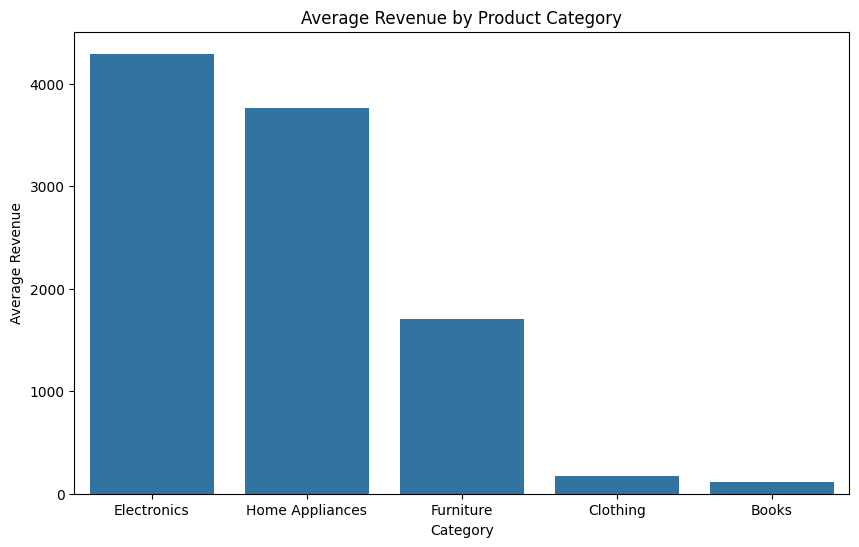

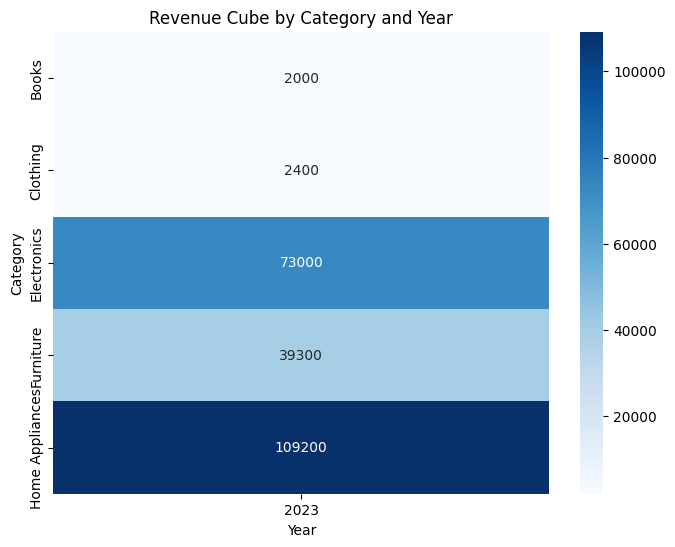

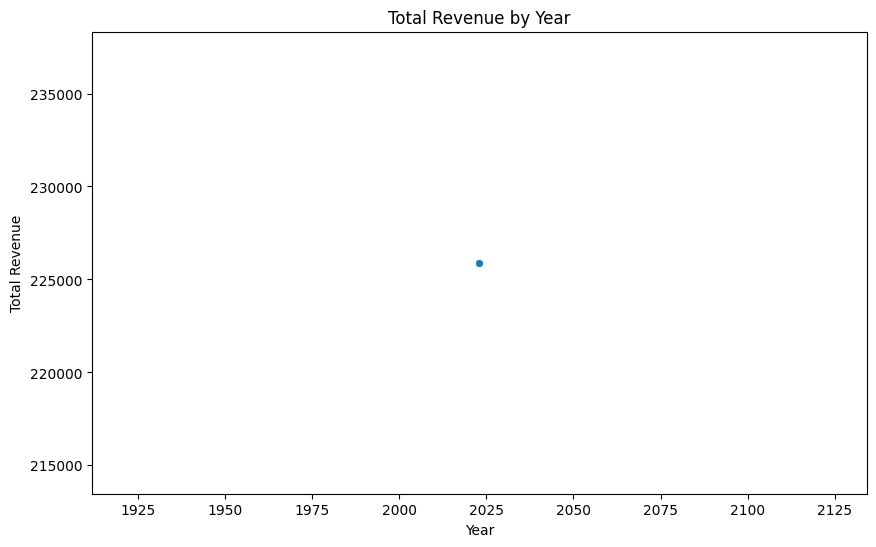

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

#SQLite database connection
conn = sqlite3.connect('olap_system.db', timeout=30)  
cursor = conn.cursor()

#Star schema creation
#Dimension tables
cursor.execute('''
    CREATE TABLE IF NOT EXISTS products (
    product_id INTEGER PRIMARY KEY,
    category TEXT NOT NULL,
    name TEXT NOT NULL,
    price Decimal NOT NULL
)''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS dates (
    date DATE PRIMARY KEY,
    year INTEGER NOT NULL,
    quarter INTEGER NOT NULL,
    month INTEGER NOT NULL,
    month_name TEXT NOT NULL
)''')

#Fact table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS sales (
    sale_id INTEGER PRIMARY KEY,
    date DATE NOT NULL,
    product_id INTEGER NOT NULL,
    quantity INTEGER NOT NULL,
    revenue Decimal NOT NULL,
    FOREIGN KEY (product_id) REFERENCES products(product_id),
    FOREIGN KEY (date) REFERENCES dates(date)
)''')

# Clear existing data to avoid UNIQUE constraint errors
cursor.execute('DELETE FROM sales')
cursor.execute('DELETE FROM products')
cursor.execute('DELETE FROM dates')
conn.commit()

#Sample data insertion
products_data = [
    (1, 'Electronics', 'Laptop', 1000.00),
    (2, 'Electronics', 'Smartphone', 500.00),
    (3, 'Home Appliances', 'Refrigerator', 800.00),
    (4, 'Home Appliances', 'Washing Machine', 600.00),
    (5, 'Furniture', 'Sofa', 300.00),
    (6, 'Furniture', 'Dining Table', 400.00),
    (7, 'Clothing', 'T-Shirt', 20.00),
    (8, 'Clothing', 'Jeans', 40.00),
    (9, 'Books', 'Novel', 15.00),
    (10, 'Books', 'Textbook', 50.00)
]
cursor.executemany('INSERT INTO products VALUES (?,?,?,?)', products_data)
dates_data = [
    ('2023-01-01', 2023, 1, 1, 'January'),
    ('2023-02-01', 2023, 1, 2, 'February'),
    ('2023-03-01', 2023, 1, 3, 'March'),
    ('2023-04-01', 2023, 2, 4, 'April'),
    ('2023-05-01', 2023, 2, 5, 'May'),
    ('2023-06-01', 2023, 2, 6, 'June'),
    ('2023-07-01', 2023, 3, 7, 'July'),
    ('2023-08-01', 2023, 3, 8, 'August'),
    ('2023-09-01', 2023, 3, 9, 'September'),
    ('2023-10-01', 2023, 4, 10, 'October'),
    ('2023-11-01', 2023, 4, 11, 'November'),
    ('2023-12-01', 2023, 4, 12, 'December')
]
cursor.executemany('INSERT INTO dates VALUES (?,?,?,?,?)', dates_data)


#GENERATE RANDOM SALES DATA
sales_data = []
np.random.seed(0)   # For reproducibility   
for i in range(1, 101):
    date = np.random.choice([d[0] for d in dates_data])
    product_id = np.random.randint(1, 11)
    quantity = np.random.randint(1, 10)
    price = next(p[3] for p in products_data if p[0] == product_id)
    revenue = quantity * price
    sales_data.append((i, date, product_id, quantity, revenue))
cursor.executemany('INSERT INTO sales VALUES (?,?,?,?,?)', sales_data)
conn.commit()
    
#OLAP Implementations
#3. ROLAP:Average revenue by product category 
query_1 = '''
    SELECT p.category, AVG(s.revenue) AS avg_revenue
    FROM sales s
    JOIN products p ON s.product_id = p.product_id
    GROUP BY p.category
    ORDER BY avg_revenue DESC
'''
df_rolap = pd.read_sql_query(query_1, conn)
print("ROLAP - Average Revenue by Product Category")
print(df_rolap)

#3. ROLAP: Total sales by year
query_2 = '''
    SELECT d.year, SUM(s.quantity) AS total_quantity, SUM(s.revenue) AS total_revenue
    FROM sales s
    JOIN dates d ON s.date = d.date
    GROUP BY d.year
    ORDER BY total_revenue DESC
'''
df_rolap_year = pd.read_sql_query(query_2, conn)
print("\nROLAP - Total Sales by Year")
print(df_rolap_year)

#3. ROLAP: Best-selling products in each category
query_3 = '''
    WITH ranked_products AS (
        SELECT p.category, p.name, SUM(s.quantity) AS total_quantity,
                RANK() OVER (PARTITION BY p.category ORDER BY SUM(s.quantity) DESC) AS rank
    FROM sales s
    JOIN products p ON s.product_id = p.product_id
    GROUP BY p.category, p.name
    )
    SELECT category, name, total_quantity
    FROM ranked_products
    WHERE rank = 1
    ORDER BY total_quantity DESC
'''
df_best_selling = pd.read_sql_query(query_3, conn)
print("\nROLAP - Best-Selling Products in Each Category")
print(df_best_selling)



#MOLAP- Data cube creation 
print("\n=== MOLAP IMPLEMENTATION ===")
#Fetch data for MOLAP operations
query_molap = '''
    SELECT p.category, d.year, d.quarter, p.name, d.month_name, s.quantity, s.revenue
    FROM sales s
    JOIN products p ON s.product_id = p.product_id
    JOIN dates d ON s.date = d.date
'''
df_molap = pd.read_sql_query(query_molap, conn)
print("Data for MOLAP operations:")
print(df_molap.head())

#Create multidimensional cube: Revenue by Category x Year
cube_revenue = df_molap.pivot_table(values='revenue', index='category', columns='year', aggfunc='sum', fill_value=0)
print("\nMOLAP - Revenue Cube by Category and Year")
print(cube_revenue)


#Create multidimensional cube: Quantity by Category x Year
quantity_cube = df_molap.pivot_table(values='quantity', index='category', columns='year', aggfunc='sum', fill_value=0)
print("\nMOLAP - Quantity Cube by Category and Year")   
print(quantity_cube)


#HOLAP- Hybrid OLAP 
print("\n=== HOLAP IMPLEMENTATION ===")
#Fetch detailed data using (SQl)ROLAP
query_holap = '''
    SELECT p.category, d.year, p.name, d.month_name, s.quantity, s.revenue
    FROM sales s
    JOIN products p ON s.product_id = p.product_id
    JOIN dates d ON s.date = d.date
    WHERE d.year = 2024
'''
df_holap = pd.read_sql_query(query_holap, conn)
print("Detailed data for HOLAP operations:")
print(df_holap.head())

#Aggregate summaries using (Pandas)MOLAP
summary_holap = df_holap.pivot_table(values='revenue', index='category', columns='month_name', aggfunc='sum', fill_value=0)
print("\nHOLAP - Revenue Summary by Category and Month for 2023")
print(summary_holap)

#OLAP OPERATIONS
print("\n=== OLAP OPERATIONS ===")

#1. Slice 

#Fixing one dimension - sales in 2023
slice_2023 = df_molap[df_molap['year'] == 2023]
print("\nSlice Operation - Sales in 2023")
print(slice_2023.head())
#The slice operation filters the data to include only sales records from the year 2023.

#2. Dice

#Apply multiple filters - Sales in 2023 for Electronics 
dice_electronics_2023 = df_molap[(df_molap['year'] == 2023) & (df_molap['category'] == 'Electronics')]
print("\nDice Operation - Electronics Sales in 2023")
print(dice_electronics_2023.head())
#The dice operation filters the data to include only sales records from the year 2023 and the Electronics category.

#3. Roll-up

#Aggregate from product (name) to category to year
rollup_category_year = df_molap.groupby(['name','category', 'year']).agg({'quantity': 'sum', 'revenue': 'sum'}).reset_index()
print("\nRoll-up Operation - Total Sales by Category and Year")
print(rollup_category_year)
#The roll-up operation aggregates the sales data to show total quantity and revenue by product category and year.

#4. Drill-down
# From year to quarter to month
drilldown_month = df_molap.groupby(['year','quarter','month_name']).agg({'quantity': 'sum', 'revenue': 'sum'}).reset_index()
print("\nDrill-down Operation - Total Sales by Year and Month")
print(drilldown_month)
#The drill-down operation provides a more detailed view of sales data by breaking it down from year to month.

#VISUALIZATIONS
print("\n=== VISUALIZATIONS ===")

#1. Bar plot -revenue by category
plt.figure(figsize=(10,6))
sns.barplot(data=df_rolap, x='category', y='avg_revenue')
plt.title('Average Revenue by Product Category')
plt.xlabel('Category')
plt.ylabel('Average Revenue')
plt.show()

#2. Sales cube heatmap(category x year)
plt.figure(figsize=(8,6))
sns.heatmap(cube_revenue, annot=True, fmt=".0f", cmap='Blues')
plt.title('Revenue Cube by Category and Year')
plt.xlabel('Year')
plt.ylabel('Category')
plt.show()

#3. Line plot - Total sales by year
plt.figure(figsize=(10,6))
sns.lineplot(data=df_rolap_year, x='year', y='total_revenue', marker='o')
plt.title('Total Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.show()

#Close the database connection
conn.close()

